In [153]:
from functions import *
pd.options.mode.chained_assignment = None  # default='warn'

In [154]:
params = read_parameters()
subfolder = params['subfolder']
file_idx = params['file_idx']
drop_initial_final_off_rows = params['drop_initial_final_off_rows']
drop_off_rows = params['drop_off_rows']
drop_outliers = params['drop_outliers']

subfolder: UF/
file_idx: 0
tmp_idx: 0
initial_feed_volume_L: 100
reset_columns_when_OFF: True
drop_initial_final_off_rows: True
drop_off_rows: True
drop_outliers: True
plot_scatterplot_matrix: False
use_default_arima_params: True
default_arima_params: [1, 1, 0]
include_arima_simulations_in_analysis: True


In [155]:
in_folder=PATH_SENSORS_DATA_EXT_UF_V1
cur_file, file_path = get_input_file(in_folder=in_folder, in_file_idx=file_idx, log=True)

file list:
0 ../data/extended/UF/v1/2023-11-08 0 clean water.csv
1 ../data/extended/UF/v1/2023-11-09 0 clean water.csv
2 ../data/extended/UF/v1/2023-11-09 1 dirty water.csv
3 ../data/extended/UF/v1/2023-11-09 2 dirty water.csv
4 ../data/extended/UF/v1/2023-11-09 3 dirty water.csv
5 ../data/extended/UF/v1/ALL_DATA.csv

input file:
../data/extended/UF/v1/2023-11-08 0 clean water.csv


In [156]:
df_all = pd.read_csv(file_path)
df_all['datetime'] = pd.to_datetime(df_all['datetime'], format='%Y-%m-%d %H:%M:%S')
df_all['date'] = pd.to_datetime(df_all['datetime']).apply(lambda x : x.date())
df_all = df_all.reset_index()

In [157]:
df_plot = drop_all_outliers(df_all, drop_initial_final_off_rows=drop_initial_final_off_rows, drop_off_rows=drop_off_rows, drop_outliers=drop_outliers, log=True)

removed 3 initial rows
removed 4 final rows
 - dropped rows: 1
removing outliers rows of column: res tot [1/m]
 - dropped rows: 1
removing outliers rows of column: prs feed_2 [kPa]
 - dropped rows: 1
removing outliers rows of column: flux [L/m^2h]
 - dropped rows: 0
removing outliers rows of column: flux [L/m^2h]
 - dropped rows: 2


In [158]:
#df_plot = df_plot[df_plot['initial feed concentration [g/L]'] > 0]

In [159]:
DATES = df_plot['date'].drop_duplicates()
DATES_IDXS = df_plot[['date', 'index']].groupby('date').min('index')
print(DATES)
print(DATES_IDXS)

0    2023-11-08
Name: date, dtype: object
            index
date             
2023-11-08      6


In [160]:
TIME_IDX  = ROW_IDX_AS_TIME
x_ax_lbl = 'time [m]' if TIME_IDX == ROW_IDX_AS_TIME else x_axis[TIME_IDX]

In [161]:
conc_lines, conc_lines_GREATER_ZERO = get_concentration_lines(df_plot, time_col='index')

   6: feed conc = 0.00 [g/L]


In [162]:
# estimate the retentate pressure using the median value of each TMP group
group_by_cols = ['TMP group']
target_col = 'prs retentate [kPa]'
target_col_est = re.sub(r'(\[.*\])$', r'est \1', target_col)
print(target_col, "->", target_col_est)
df_tmp = pd.DataFrame(df_plot[group_by_cols + [target_col]].groupby(group_by_cols).median()[target_col]).reset_index().rename(columns={target_col : target_col_est})
#print(df_tmp)
df_plot = df_plot.join(df_tmp.set_index(group_by_cols), on=group_by_cols)
del(df_tmp)

prs retentate [kPa] -> prs retentate est [kPa]


In [163]:
group_by_cols = ['TMP group']
target_col = ['index', 'time [m]', 'TMP [kPa]']
pd.DataFrame(df_plot[group_by_cols + target_col].groupby(group_by_cols).agg(["min", "median", "max"])).reset_index(drop=True).drop(labels=[('index', 'median'), ('time [m]', 'median'), ('index', 'max'), ('time [m]','max')], axis=1) # 

index time [m] TMP [kPa]                    
    min      min       min    median       max
0     6      7.0  395.5530  404.4822  414.0444
1    74     75.0  376.5643  384.1824  393.6542
2    86     87.0  341.7517  346.5893  351.5173
3   125    126.0  285.4185  289.1258  292.8783
4   158    159.0  245.3161  248.7748  254.4488
5   186    187.0  177.6349  180.0763  182.3821
6   217    218.0  142.4606  144.7211  147.4338

        prs retentate [kPa]  absolute error  relative error  squared error
min               36.169000        0.000000        0.000000       0.000000
median           237.585000        1.152900        0.007309       1.329689
mean             200.546500        1.765257        0.009390       7.038268
max              302.734400       15.191050        0.052126     230.768000
var             7771.273005        3.939725        0.000074     415.338190
std               88.154824        1.984874        0.008598      20.379848

Error metrics:
R^2      0.9991
RMSE     2.6530
MAE      1.7653
MedAE    1.1529
maxAE   15.1911
MAPE     0.0094
maxAPE   0.0521


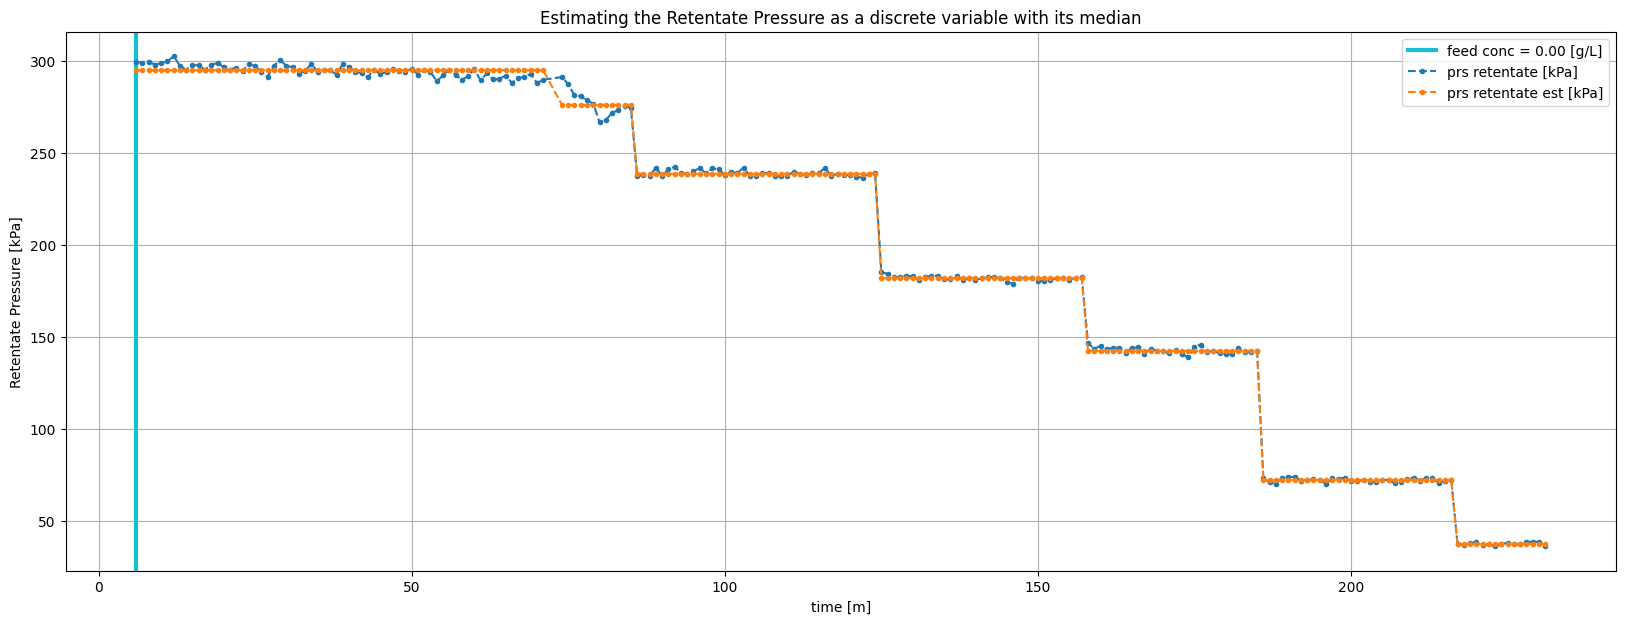

In [164]:
title='Estimating the Retentate Pressure as a discrete variable with its median'
x_col = 'prs retentate est [kPa]'
x = df_plot[[x_col]]
y_col = 'prs retentate [kPa]'
y_ax_lbl = 'Retentate Pressure [kPa]'
y = df_plot[y_col]
#model, y_pred, intercept, coeffs = call_linear_model(x, y)
y_pred = df_plot[x_col]
y_dict = {
    y_col   : y,
    x_col   : y_pred,
}
#print(f"\np-values:\n{model.pvalues}\n")
#print(get_summary(df_plot, ['prs retentate [kPa]', 'prs retentate est [kPa]'], stats=["min", "median", "mean",  "max", "var", "std"], conf_int=0.95))
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)
plot_time_series_1_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_ax_lbl, y_ax_lbl=y_ax_lbl, title=title, concentration_lines=conc_lines)
if cur_file == 'ALL_DATA.csv' :
    plot.savefig(f'{PATH_IMAGES}/retentate_pressure_vs_median.png')

pressure permeate median: 20.8876 excluding clear water samples

        prs permeate [kPa]  absolute error  relative error  squared error
min              19.712100        0.000000        0.000000       0.000000
median           20.887600        0.452100        0.021186       0.204394
mean             20.926746        0.493679        0.023503       0.355470
max              22.876900        1.989300        0.086957       3.957314
var               0.355525        0.112253        0.000244       0.236564
std               0.596259        0.335042        0.015623       0.486379

Error metrics:
R^2     -0.0043
RMSE     0.5962
MAE      0.4937
MedAE    0.4521
maxAE    1.9893
MAPE     0.0235
maxAPE   0.0870


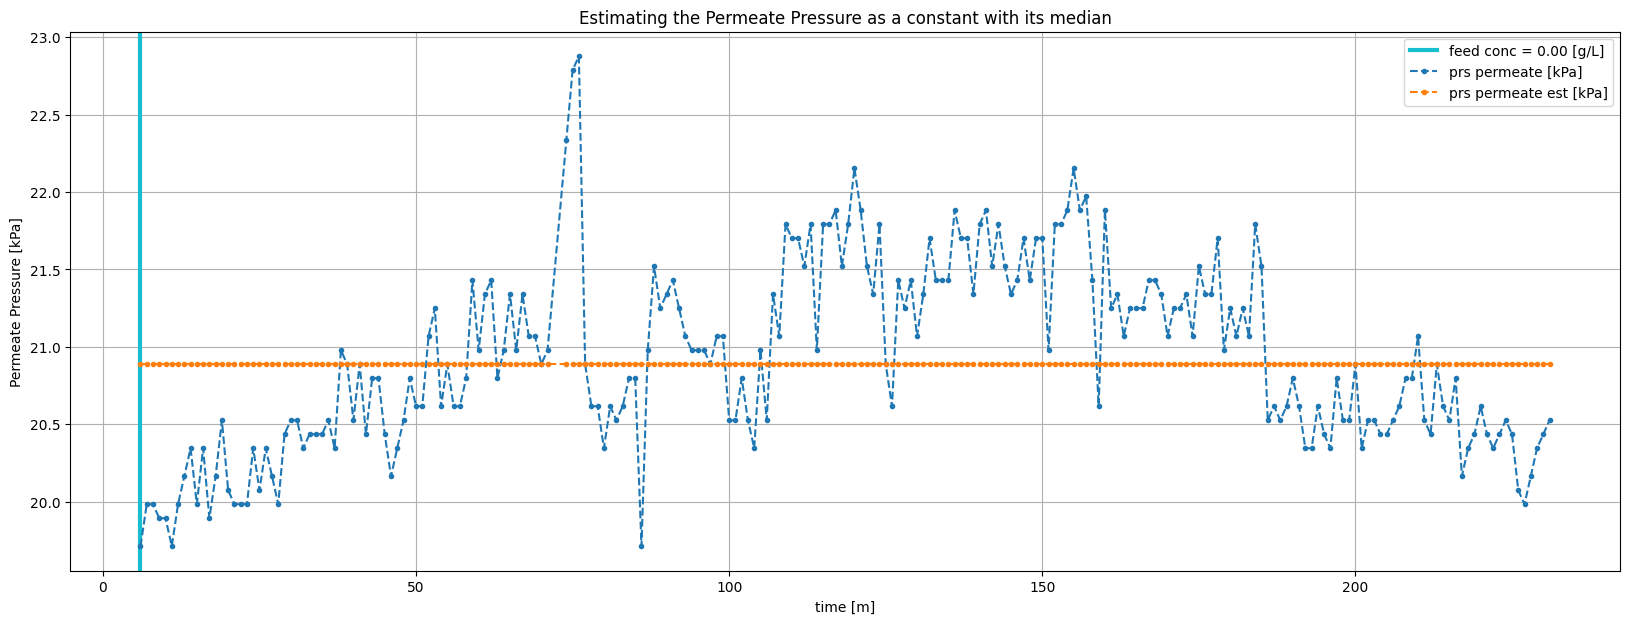

In [165]:
# ESTIMATING PERMEATE PRESSURE
title='Estimating the Permeate Pressure as a constant with its median'
x_col = 'prs permeate est [kPa]'
y_col = 'prs permeate [kPa]'
y_ax_lbl = 'Permeate Pressure [kPa]'
# estimate using only the non clear water if there are dirty water samples
cur_col = df_plot[df_plot['initial feed concentration [g/L]'] > 0][y_col]
if len(cur_col) < 5 :
    cur_col = df_plot[y_col]
PRS_PERMEATE_EST = cur_col.median()
df_plot[x_col] = PRS_PERMEATE_EST
y = df_plot[y_col]
y_pred = df_plot[x_col]
y_dict = {
    y_col   : y,
    x_col   : y_pred,
}
print(f"pressure permeate median: {PRS_PERMEATE_EST} excluding clear water samples\n")
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)
cur_ax = plot_time_series_1_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_ax_lbl, y_ax_lbl=y_ax_lbl, title=title, concentration_lines=conc_lines)
#cur_ax.ylim(0,600)
if cur_file == 'ALL_DATA.csv' :
    write_estimated_coefficients_to_json(FILE_EST_COEFFS, key=y_col, x_cols=None, intercept=PRS_PERMEATE_EST, coefficients=[])
    plot.savefig(f'{PATH_IMAGES}/linear_model_permeate_pressure.png')

   6: feed conc = 0.00 [g/L]
Intercept:    2763.9403662485174
Coefficients: [-7.187864186589369]
                             OLS Regression Results                             
Dep. Variable:     flow retentate [L/h]   R-squared:                       0.994
Model:                              OLS   Adj. R-squared:                  0.994
Method:                   Least Squares   F-statistic:                 3.844e+04
Date:                  Tue, 11 Jun 2024   Prob (F-statistic):          9.68e-251
Time:                          21:20:37   Log-Likelihood:                -1185.2
No. Observations:                   224   AIC:                             2374.
Df Residuals:                       222   BIC:                             2381.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-

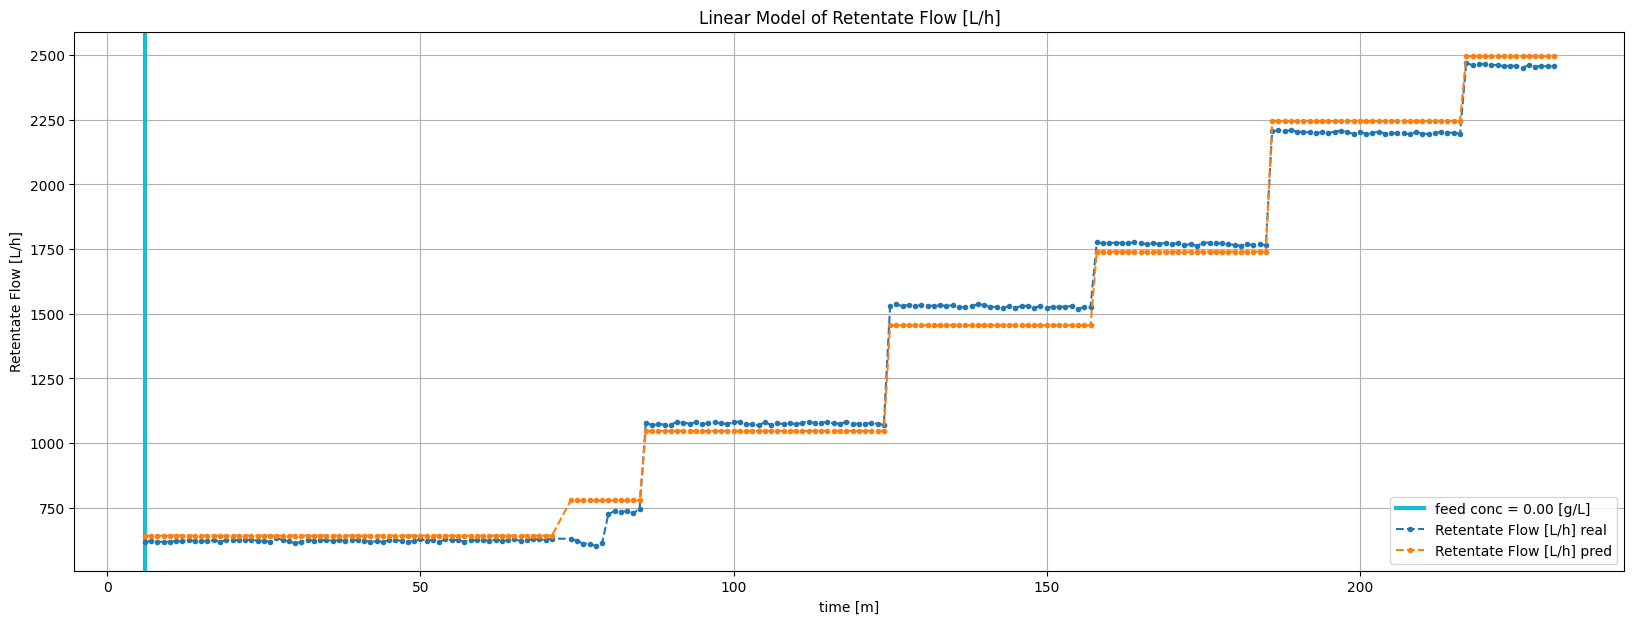

In [166]:
# ESTIMATING RETENTATE FLOW
# TODO TO IMPROVE.. include conc_feed [g/L] !
cur_df = df_plot
cur_df = cur_df[cur_df['initial feed concentration [g/L]'] > 0]
if len(cur_df) <= 5 :
    cur_df = df_plot

cur_conc_lines, _ = get_concentration_lines(cur_df, time_col='index')

y_ax_lbl = 'Retentate Flow [L/h]'
title = 'Linear Model of ' + y_ax_lbl

x_cols = ['prs retentate est [kPa]'] 
x = cur_df[x_cols] #'flow permeate [L/h]', 'TMP est [kPa]', 'initial permeate concentration [g/L]', 'initial feed concentration [g/L]', 'prs retentate [kPa]', 'res tot [1/m]', 'viscosity permeate [Pa s]', 'flow permeate [L/h]'
y_col = 'flow retentate [L/h]'
y = cur_df[y_col]
model, y_pred, intercept, coeffs = call_linear_model(x, y)
df_plot['flow retentate est [kPa]'] = y_pred
# value obtained from the model containing all the samples with initial feed concentration > 0
#y_fixed   = predict_y(x, 2841.34618760, [-6.50123444])
y_dict = {
    y_ax_lbl + ' real'  : y,
    y_ax_lbl + ' pred'  : y_pred,
}
print(f"\np-values:\n{model.pvalues}\n")
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)
plot_time_series_1_axis(x=cur_df[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_ax_lbl, y_ax_lbl=y_ax_lbl, title=title, x_format=x_format[0], concentration_lines=cur_conc_lines)
del(cur_df)
if cur_file == 'ALL_DATA.csv' :
    write_estimated_coefficients_to_json(FILE_EST_COEFFS, key=y_col, x_cols=x_cols, intercept=intercept, coefficients=coeffs)
    plot.savefig(f'{PATH_IMAGES}/linear_model_retentate_flow.png')

Intercept:    34.45950223860224
Coefficients: [0.9830127199061458]
                            OLS Regression Results                            
Dep. Variable:       prs feed_1 [kPa]   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.747e+05
Date:                Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                        21:20:39   Log-Likelihood:                -519.27
No. Observations:                 224   AIC:                             1043.
Df Residuals:                     222   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

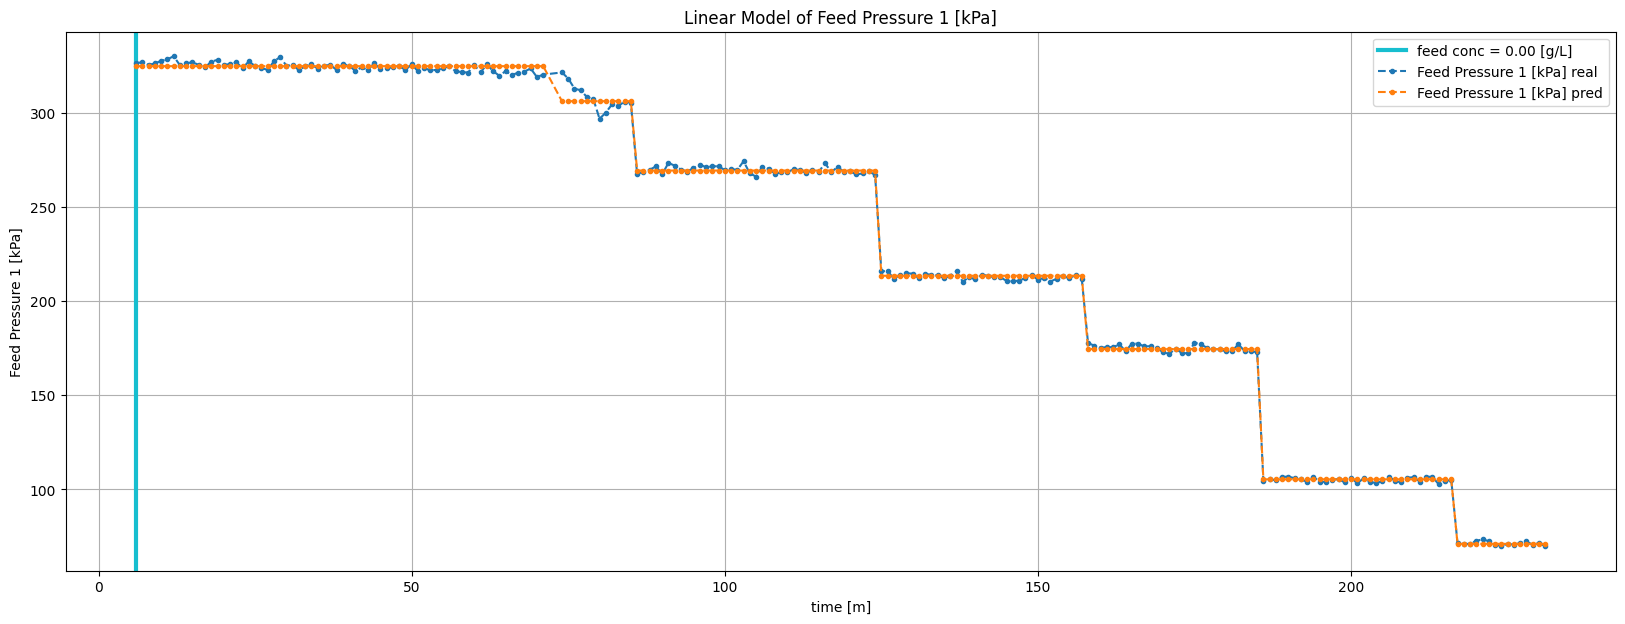

In [167]:
# ESTIMATING PRESSURE PUMP OULET PRESSURE
y_ax_lbl = 'Feed Pressure 1 [kPa]'
title = 'Linear Model of ' + y_ax_lbl
x_cols = ['prs retentate est [kPa]']
x = df_plot[x_cols]
y_col = 'prs feed_1 [kPa]'
y = df_plot[y_col]
model, y_pred, intercept, coeffs = call_linear_model(x, y)
df_plot['prs feed_1 est [kPa]'] = y_pred
#y_fixed = predict_y(x, 32, [1])
y_dict = {
    y_ax_lbl + ' real'  : y,
    y_ax_lbl + ' pred'  : y_pred,
}
print(f"\np-values:\n{model.pvalues}\n")
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)
plot_time_series_1_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_ax_lbl, y_ax_lbl=y_ax_lbl, title=title, x_format=x_format[0], concentration_lines=conc_lines)
#cur_ax.ylim(0,600)
if cur_file == 'ALL_DATA.csv' :
    write_estimated_coefficients_to_json(FILE_EST_COEFFS, key=y_col, x_cols=x_cols, intercept=intercept, coefficients=coeffs)
    plot.savefig(f'{PATH_IMAGES}/linear_model_feed_pressure_1.png')

Intercept:    255.0057941347025
Coefficients: [1.0155351227267246]
                            OLS Regression Results                            
Dep. Variable:       prs feed_2 [kPa]   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.258e+05
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          1.02e-307
Time:                        21:20:40   Log-Likelihood:                -614.01
No. Observations:                 224   AIC:                             1232.
Df Residuals:                     222   BIC:                             1239.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

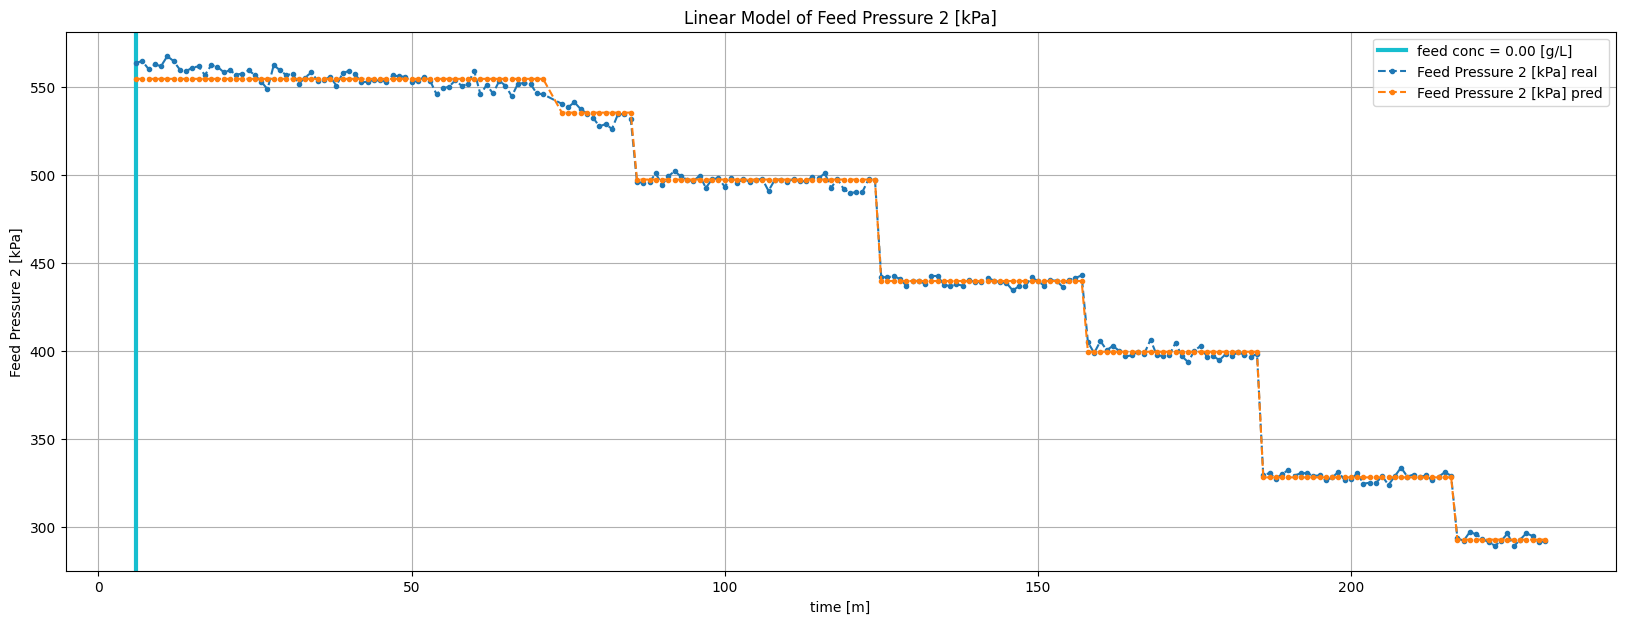

In [168]:
# ESTIMATING CIRCULATION PUMP OULET PRESSURE == FEED PRESSURE ON THE MEMBRANE
y_ax_lbl = 'Feed Pressure 2 [kPa]'
title = 'Linear Model of ' + y_ax_lbl
x_cols = ['prs retentate est [kPa]']
x = df_plot[x_cols]
y_col = 'prs feed_2 [kPa]'
y = df_plot[y_col]
model, y_pred, intercept, coeffs = call_linear_model(x, y)
df_plot['prs feed_2 est [kPa]'] = y_pred
y_dict = {
    y_ax_lbl + ' real'  : y,
    y_ax_lbl + ' pred'  : y_pred,
}
print(f"\np-values:\n{model.pvalues}\n")
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)
plot_time_series_1_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_ax_lbl, y_ax_lbl=y_ax_lbl, title=title, x_format=x_format[0], concentration_lines=conc_lines)
if cur_file == 'ALL_DATA.csv' :
    write_estimated_coefficients_to_json(FILE_EST_COEFFS, key=y_col, x_cols=x_cols, intercept=intercept, coefficients=coeffs)
    plot.savefig(f'{PATH_IMAGES}/linear_model_feed_pressure_2.png')

        prs feed_2 [kPa]  absolute error  relative error  squared error
min           289.171000        0.017070        0.000034       0.000291
median        492.485900        2.091862        0.005093       4.375886
mean          458.566563        2.848885        0.006124      14.073932
max           567.581700       12.851987        0.022643     165.173566
var          8027.423973        5.984502        0.000023     534.972390
std            89.595893        2.446324        0.004789      23.129470

Error metrics:
R^2      0.9982
RMSE     3.7515
MAE      2.8489
MedAE    2.0919
maxAE   12.8520
MAPE     0.0061
maxAPE   0.0226


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

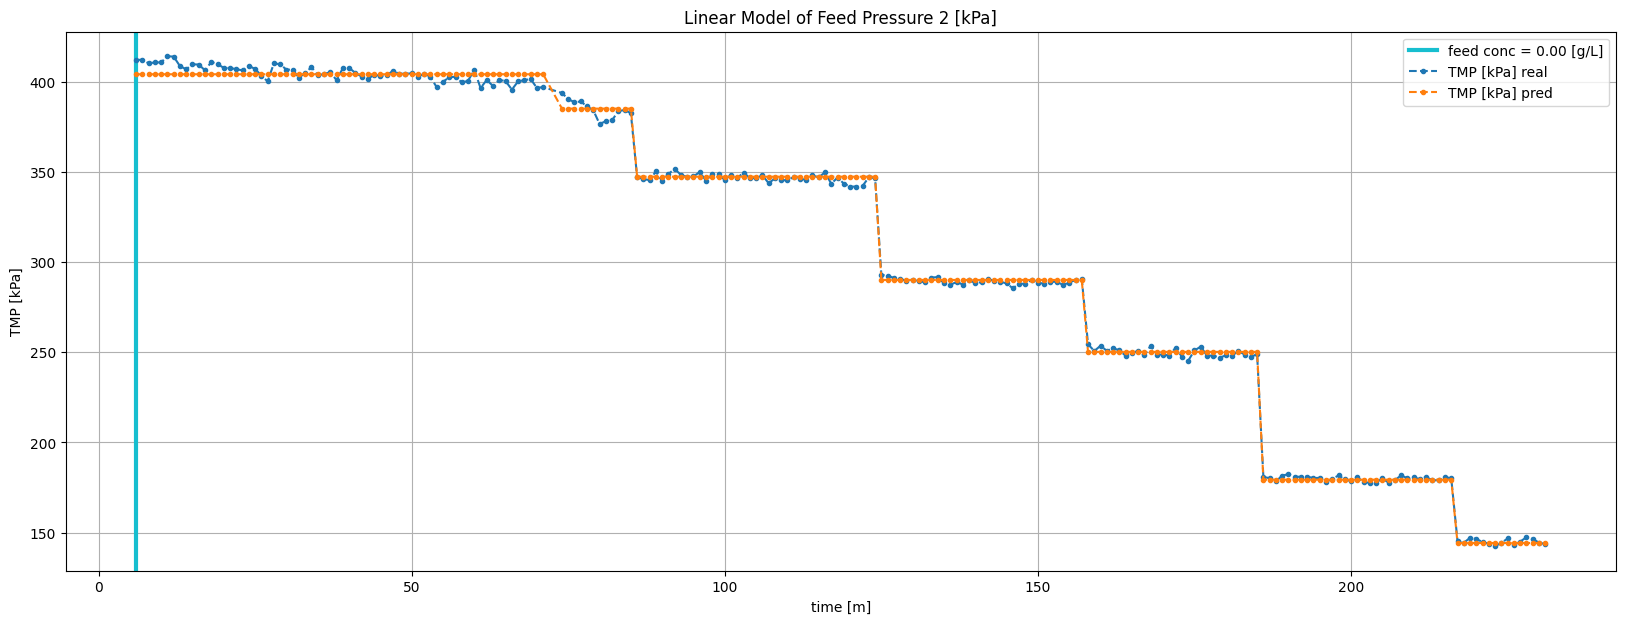

In [169]:
# checking TMP estimated
y_ax_lbl = 'TMP [kPa]'
title = 'Linear Model of ' + y_ax_lbl
df_plot['TMP est [kPa]'] = 0.5 * (df_plot['prs feed_2 est [kPa]'] + df_plot['prs retentate est [kPa]']) - df_plot['prs permeate est [kPa]'] 
y_dict = {
    y_ax_lbl + ' real'  : df_plot['TMP [kPa]'],
    y_ax_lbl + ' pred'  : df_plot['TMP est [kPa]'],
}
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)
plot_time_series_1_axis(x=df_plot[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_ax_lbl, y_ax_lbl=y_ax_lbl, title=title, x_format=x_format[0], concentration_lines=conc_lines)

   0: feed conc = 0.00 [g/L]
Intercept:    3364724378734.171
Coefficients: [-590102457248807.5]
                            OLS Regression Results                            
Dep. Variable:          res tot [1/m]   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     1620.
Date:                Tue, 11 Jun 2024   Prob (F-statistic):          5.70e-104
Time:                        17:51:37   Log-Likelihood:                -5730.9
No. Observations:                 224   AIC:                         1.147e+04
Df Residuals:                     222   BIC:                         1.147e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------

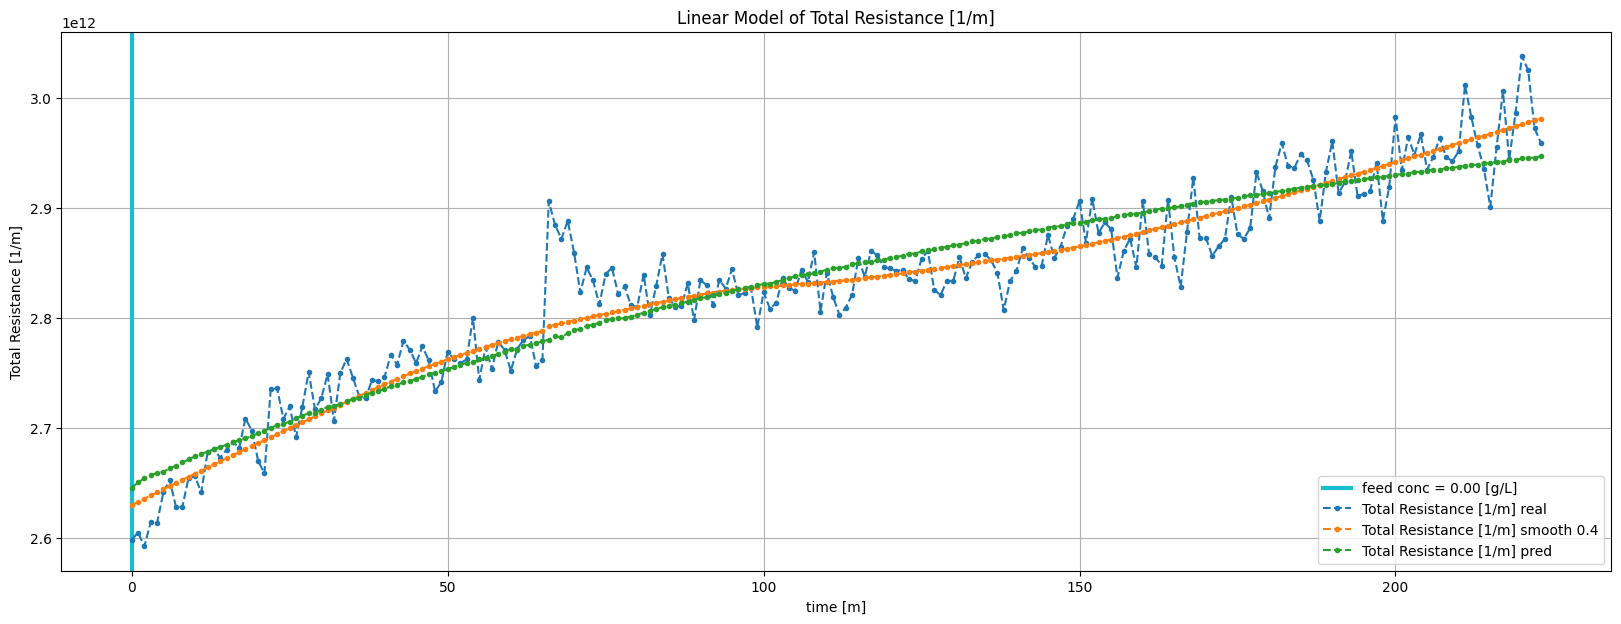

In [152]:
# ESTIMATING TOTAL RESISTANCE 
# actually is this linear model is only used to initialize at the beginning the res tot
cur_df = df_plot
cur_df['changed anything'] = (cur_df['changed TMP'] | cur_df['changed concentration']).astype(int)
#cur_df = cur_df[cur_df['changed anything'] == 1]
if cur_file == 'ALL_DATA.csv' : 
    cur_df = cur_df[(cur_df['initial feed concentration [g/L]'] == 0)].reset_index()
    cur_df = cur_df[cur_df['file_idx'] == cur_df.loc[0, 'file_idx']]
if len(cur_df) <= 5 :
    cur_df = df_plot

cur_conc_lines, _ = get_concentration_lines(cur_df, time_col='index', log=False)

pct = 0.4
smoothed_col = f'res tot [1/m] smooth {pct}'
cur_df[smoothed_col] = smooth_data_lowess(cur_df['time [m]'], cur_df['res tot [1/m]'], pct=pct)

y_ax_lbl = 'Total Resistance [1/m]'
title = 'Linear Model of ' + y_ax_lbl
x_cols = [
    #'TMP est [kPa]', 
    'viscosity permeate [Pa s]',
    #'initial feed concentration [g/L]',
    #'flux [L/m^2h]'
]
x = cur_df[x_cols]
y_col = 'res tot [1/m]' #smoothed_col
y = cur_df[y_col]
model, y_pred, intercept, coeffs = call_linear_model(x, y)
cur_df['res tot est [1/m]'] = y_pred
#y_fixed = predict_y(x, 3.3090250768740557e12, [-1.48561865e08, -4.76160396e14])
y_dict = {
    y_ax_lbl + ' real'  : cur_df['res tot [1/m]'],
    y_ax_lbl + f' smooth {pct}'  : cur_df[smoothed_col],
    #y_ax_lbl + ' fixed'  : y_fixed,
    y_ax_lbl + ' pred'  : y_pred,
}
print(f"\np-values:\n{model.pvalues}\n")
print(get_error_stats(y, y_pred, y_col))
print()
compute_error_metrics(y, y_pred)
plot_time_series_1_axis(x=cur_df[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_ax_lbl, y_ax_lbl=y_ax_lbl, title=title, x_format=x_format[0], concentration_lines=cur_conc_lines)
#del(cur_df)
#cur_ax.ylim(0,600)
if cur_file == 'ALL_DATA.csv' :
    write_estimated_coefficients_to_json(FILE_EST_COEFFS, key=y_col, x_cols=x_cols, intercept=intercept, coefficients=coeffs)
    #plot.savefig(f'{PATH_IMAGES}/linear_model_feed_pressure_1.png')

average pressure permeate: 21.9727


Intercept:    0.0022436217683312384
Coefficients: [1.4967978142496674e-05, -0.00034560518411628127]
                            OLS Regression Results                            
Dep. Variable:       temperature [°C]   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.894e+05
Date:                Tue, 11 Jun 2024   Prob (F-statistic):               0.00
Time:                        17:46:54   Log-Likelihood:                 2809.7
No. Observations:                 260   AIC:                            -5613.
Df Residuals:                     257   BIC:                            -5603.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

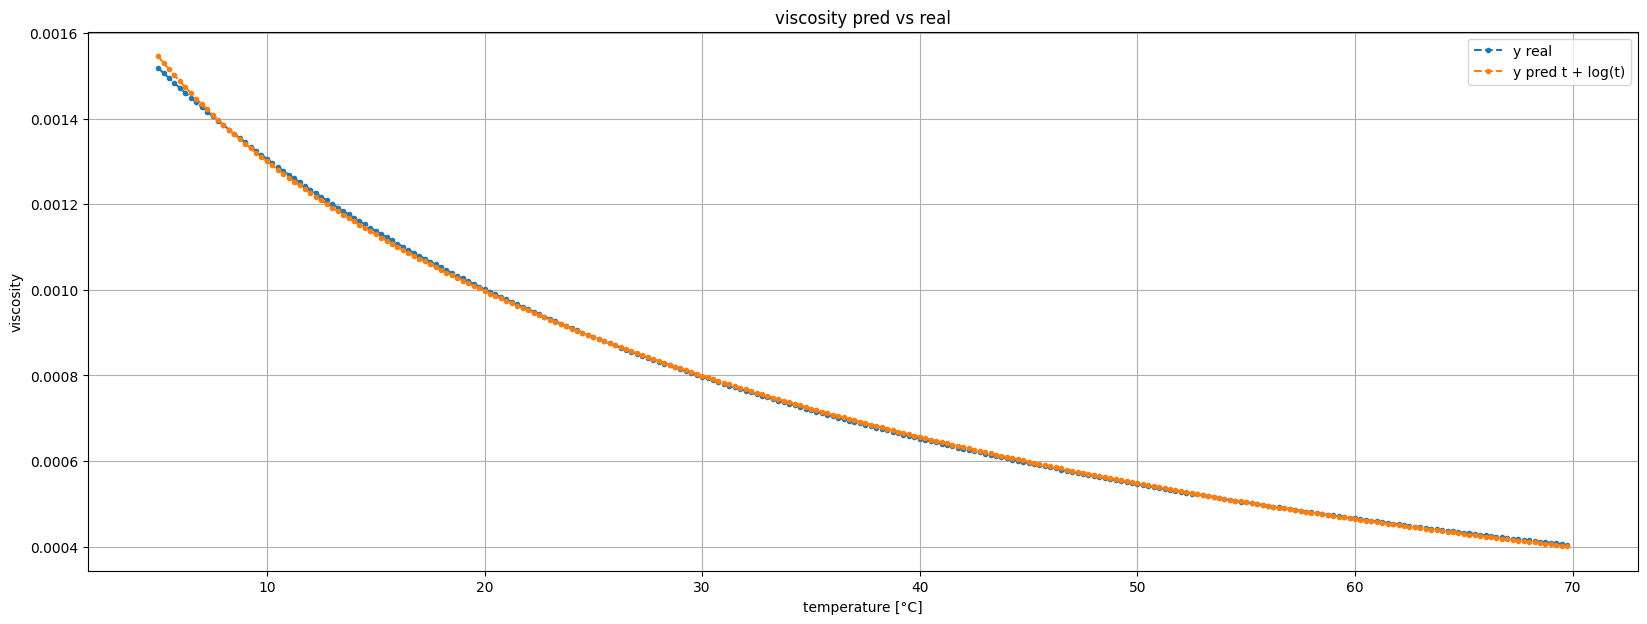

In [ ]:
# ESTIMATING VISCOSITY
# since we assume constant permeate pressure, only temperature will be included in the model
# NB ok only for temperature >= 5 and <70, which is our interval of interest
# better model for 1 <= temperature <= 100 including also log temperature
# normally ultrafiltration [5,70] is enough, actually tipically <= 50
print("average pressure permeate:", PRS_PERMEATE_EST)
df_visc = pd.DataFrame()
df_visc['temperature [°C]'] = list(np.arange(5, 70, 0.25))
#df_visc['log temperature [°C]'] = df_visc['temperature [°C]'].apply(lambda x : math.log(x))
df_visc['sqrt temperature [°C]'] = df_visc['temperature [°C]'].apply(lambda x : math.sqrt(x))
x = df_visc[['temperature [°C]', 'sqrt temperature [°C]']]
y = df_visc['temperature [°C]'].apply(lambda x : calc_viscosity(x, pressure_Pa=(101325+PRS_PERMEATE_EST), element='Water'))
df_visc['viscosity [Pa s]'] = y
model, y_pred, intercept, coeffs = call_linear_model(x, y)
y_dict = {
    'y real'          : y,
    'y pred t + log(t)'  : y_pred,
}
title = 'viscosity pred vs real'
y_ax_lbl='viscosity'
print(f"\np-values:\n{model.pvalues}\n")
print(get_error_stats(y, y_pred, 'viscosity [Pa s]'))
print()
compute_error_metrics(y, y_pred)
plot_time_series_1_axis(x=df_visc['temperature [°C]'], y_series=y_dict, x_ax_lbl='temperature [°C]', y_ax_lbl=y_ax_lbl, title=title, x_format=None)

In [ ]:
# ESTIMATING TEMPERATURE
if cur_file not in ['ALL_DATA.csv'] :
    df_temp = df_all
    #dates = pd.to_datetime(df_all['datetime']).apply(lambda x : x.date())
    #df_temp = df_temp[dates == datetime.date(2023, 11, 9)]
    df_temp['filter'] = ((df_plot['jumped temperature'] == 1) | (df_plot['is_ON'] == True))
    df_temp = df_temp[df_temp['filter'] == True]

    #if file_idx == 5 :
        # A)
        #df_temp = df_temp[df_temp['time [m]'] <= 22]
        # B)
        # df_temp = df_temp[df_temp['time [m]'] >= 27]
        # df_temp = df_temp[df_temp['time [m]'] <= 100]
        # C)
        # df_temp = df_temp[df_temp['time [m]'] >= 149]

    df_temp = df_temp.reset_index(drop=True)
    df_temp['time [m]'] = df_temp['time [m]'] - df_temp.loc[0, 'time [m]'] + 1

    df_init = df_temp[df_temp['time [m]'] <= 2]     #Intercept:     8.06931000000000, Coefficients: [1.6493]
    df_next = df_temp[df_temp['time [m]'] >= 2]     #Intercept:    12.68446247249464, Coefficients: [0.10259717]

    #if cur_file == '2023-11-08 clean water.csv' :
    #    # clean membrane
    #    df_init = df_temp[df_temp['time [m]'] <= 2]     #Intercept:     8.06931000000000, Coefficients: [1.6493]
    #    df_next = df_temp[df_temp['time [m]'] >= 2]     #Intercept:    12.68446247249464, Coefficients: [0.10259717]
    #if cur_file == '2023-11-09 clean + dirty water.csv' :
    #    # clean membrane
    #    df_init = df_temp[df_temp['time [m]'] <=  2]    #Intercept:    10.89049000000000, Coefficients: [3.85199]
    #    df_next = df_temp[df_temp['time [m]'] >=  2]    #Intercept:    18.56241843290043, Coefficients: [0.12108152]

    y_col = 'temperature [°C]'
    x1 = df_init[['time [m]']]
    y1 = df_init[y_col]
    x2 = df_next[['time [m]']]
    y2 = df_next[y_col]

    print('t <= 2 minutes:')
    model1, y_pred1, intercept1, coeffs1 = call_linear_model(x1, y1)
    print('t >= 2 minutes:')
    model2, y_pred2, intercept2, coeffs2 = call_linear_model(x2, y2)
    print(f"\np-values:\n{model2.pvalues}\n")
    print(get_error_stats(y2, y_pred2, y_col))
    print()
    compute_error_metrics(y2, y_pred2)

    y_real = df_temp[y_col]
    fig, ax1 = plot.subplots(figsize=(30,10))
    ax1.plot(df_temp[x_axis[TIME_IDX]], y_real,  color='blue',  marker='o', linestyle='--', label='temp real')
    ax1.plot(df_init[x_axis[TIME_IDX]], y_pred1, color='gold',  marker='o', linestyle='--', label='pred init jump')
    ax1.plot(df_next[x_axis[TIME_IDX]], y_pred2, color='green', marker='o', linestyle='--', label='pred slope')
    ax1.grid()
    ax1.legend(loc='upper left')
    del(df_init, df_next, df_temp)

In [ ]:
#if cur_file not in ['ALL_DATA.csv'] :
#    y_dict = {
#        'temperature'  : df_all['temperature [°C]']
#    }
#    ON_COLOR  = 'green'
#    OFF_COLOR = 'red'
#    fig, ax = plot.subplots()
#    ax.plot(df_all[x_axis[1]], df_all['temperature [°C]'], color='black') #, linestyle='--')
#    ax.scatter(df_ON[x_axis[1]], df_ON['temperature [°C]'], color=ON_COLOR,  marker='o', label='ON')
#    ax.scatter(df_OF[x_axis[1]], df_OF['temperature [°C]'], color=OFF_COLOR, marker='o', label='OFF')
#
#    if x_format != None :
#        xformatter = mdates.DateFormatter(x_format[1])
#        plot.gcf().axes[0].xaxis.set_major_formatter(xformatter)
#    title = 'Temperature and ON-OFF over Time'
#    plot.title(title)
#    plot.axhline(8, label='Aalborg temp.')
#    plot.legend()
#    #plot.savefig(f'../images/{date} {title}.png')
#    plot.show()

In [ ]:
estimated_temperature_coefficients = {
    '2023-11-08 0 clean water.csv' : 0.10297992162874003,
    '2023-11-09 0 clean water.csv' : 0.12166098245614032,
    '2023-11-09 1 dirty water.csv' : 0.12934391831357014,
    '2023-11-09 2 dirty water.csv' : 0.12425824273504338,
    '2023-11-09 3 dirty water.csv' : 0.11615066142460734,
}
average_temperature_slope = 0
for coeff in estimated_temperature_coefficients.values() :
    average_temperature_slope += coeff
average_temperature_slope /= len(estimated_temperature_coefficients)
print(average_temperature_slope)

0.11887874531162024


In [ ]:
## CALCULATING CROSSFLOW VELOCITY
#mbn_num = 3
#mbn_channels = 30
#mbn_channel_dim =  0.003
#membrane_section = mbn_channels * mbn_num * (mbn_channel_dim/2)**2 * math.pi
# print("crossflow velocity included!")
#cur_df = df_plot
# vlct_crsflow = liters__to__m3(flow_feed) / (area_tot * SECS_PER_HRS);
#area_tot = mbn_num * 0.33
#mbn_diam = mbn_num * 0.025
#mbn_len  = 1.178

#                    [m/s]   =  [m^3 / h]                           / [m^2]
#cur_df['vlct crsflow [m/s]'] = (cur_df['flow feed [L/h]'] / (1000 * 3600.0)) / membrane_section
#                    [L/h]   =  [m^3 / h]                           / [m^2]
#cur_df['flow retentate est [L/h]'] = 1.25 * 0.25 * math.pi * (3600 * cur_df['vlct crsflow [m/s]']) * mbn_diam**2 * mbn_len * mbn_channels * mbn_num
#cur_df['dis'] = cur_df['flow retentate [L/h]'] / cur_df['flow retentate est [L/h]']

#x = cur_df[['TMP est [kPa]']]
#y_col = 'vlct crsflow [m/s]'
#y = cur_df[y_col]
#model, y_pred, intercept, coeffs = call_linear_model(x, y)

#y_dict = {
#    'vlct crsflow' : df_plot['vlct crsflow [m/s]'],
#    'vlct crsflow est' : y_pred,
#    'TMP' : df_plot['TMP [kPa]'],
#    'TMP est' : df_plot['TMP est [kPa]']
#}
#y_ax_lbl = ['vlct crsflow [m/s]', 'TMP [kPa]']
#plot_time_series_2_axis(x=cur_df[x_axis[TIME_IDX]], y_series=y_dict, x_ax_lbl=x_ax_lbl, y_ax_lbl=y_ax_lbl, title='vlct crsflow vs TMP', x_format=x_format[0], secondary_y=['TMP', 'TMP est'])